# Testing Snake creation and evolution
Much (but not all) of this code will be duplicated to [main.py](../main.py)

In [1]:
### Imports ###
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import tsnake.initialize as init
from tsnake.snake import TSnake, Element, Node
from tsnake.grid import Grid, Point
from tsnake.utils import dist, seg_intersect

## Load images, compute masked reigons
### Link to images I used for the plane are [here](https://drive.google.com/open?id=1TK6rc-USD4KKI0Bss_B6r4l13oAD2uqG)

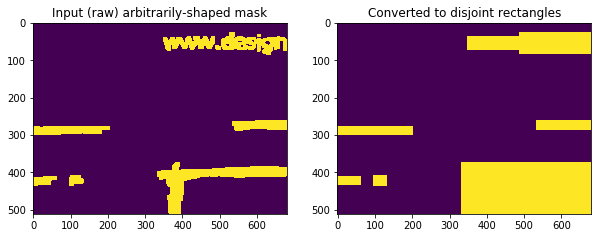

In [2]:
msk_path = '../examples/places2/case1_mask.png'
img_path = '../examples/places2/case1_raw.png'


# msk_path = '../examples/test/plane_mask.png'
# gt_msk_path = '../examples/test/plane_mask_ground_truth.png'
# img_path = '../examples/test/plane.png'
# gt_mask = init.load_mask(path=gt_msk_path, convert=True)
mask = init.load_mask(path=msk_path, convert=True)
image = init.load_grayscale_image(img_path)

regions = init._find_disjoint_masked_regions(mask)

# NOTE: Uncomment to visialize initial masked reigons
init.visualize_masked_regions(mask, regions)

regions = init.compute_masked_regions(image, mask)

### Initializing Ground truth Reigons

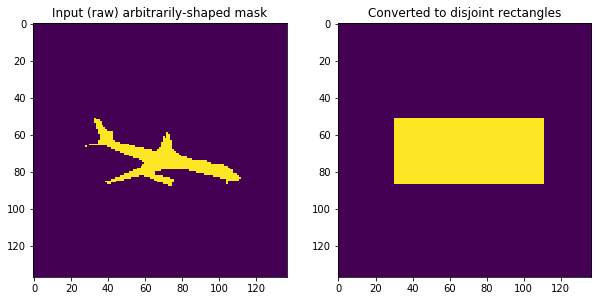

In [3]:
### Ground Truth reigons
gt_reigons = init._find_disjoint_masked_regions(gt_mask)

# NOTE: Uncomment to visialize initial masked reigons
init.visualize_masked_regions(gt_mask, gt_reigons)

gt_regions = init.compute_masked_regions(image, gt_mask)

## Initialize t-snakes
_Note: Length 17 t-snake (i.e. the sort one) is visibly wrong, not sure how we can fix that_
*Legend*
* Green lines: Normal vectors
* White Nodes: Initial 5 nodes of the snake
* Yellow Nodes: Final 5 nodes of the snake
    * This tells us which way the snake was initialized, Counter Clockwise or Clockwise

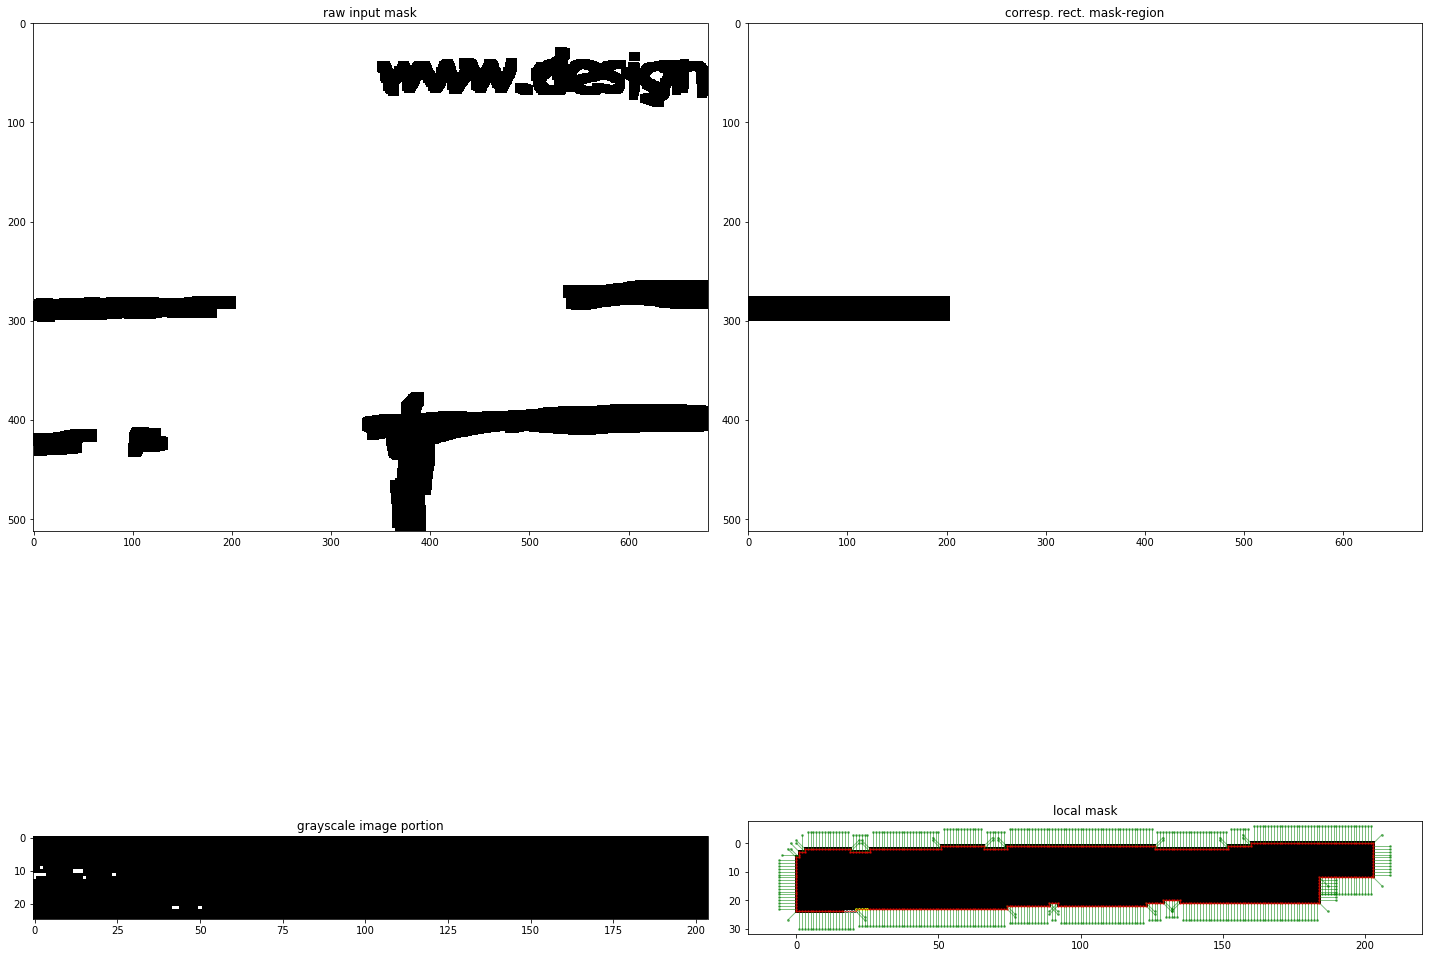

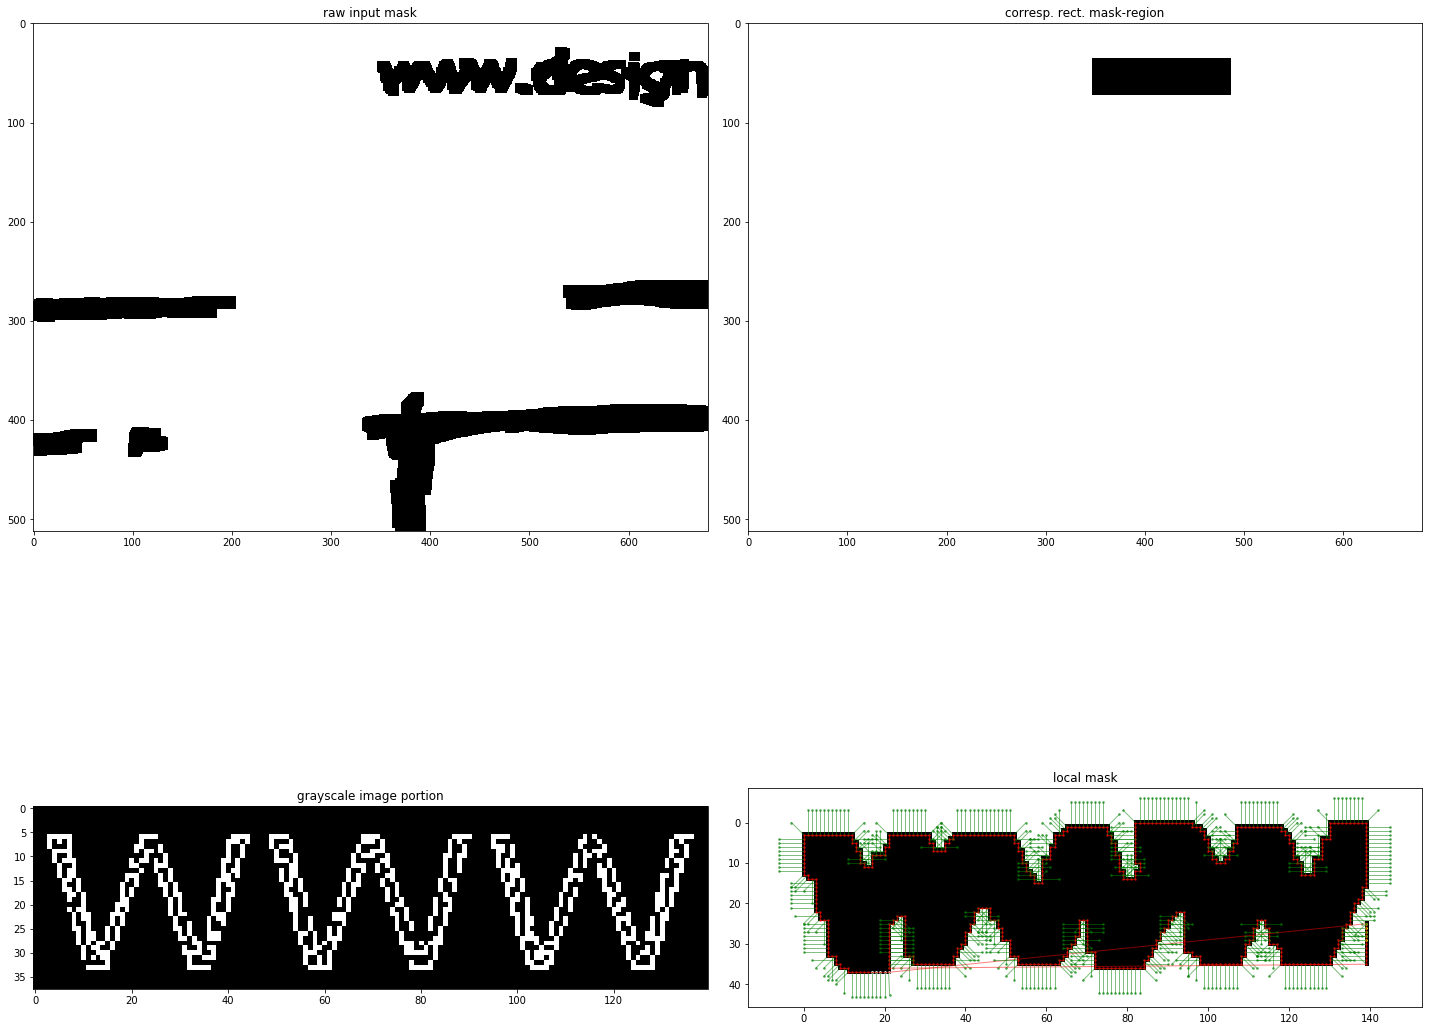

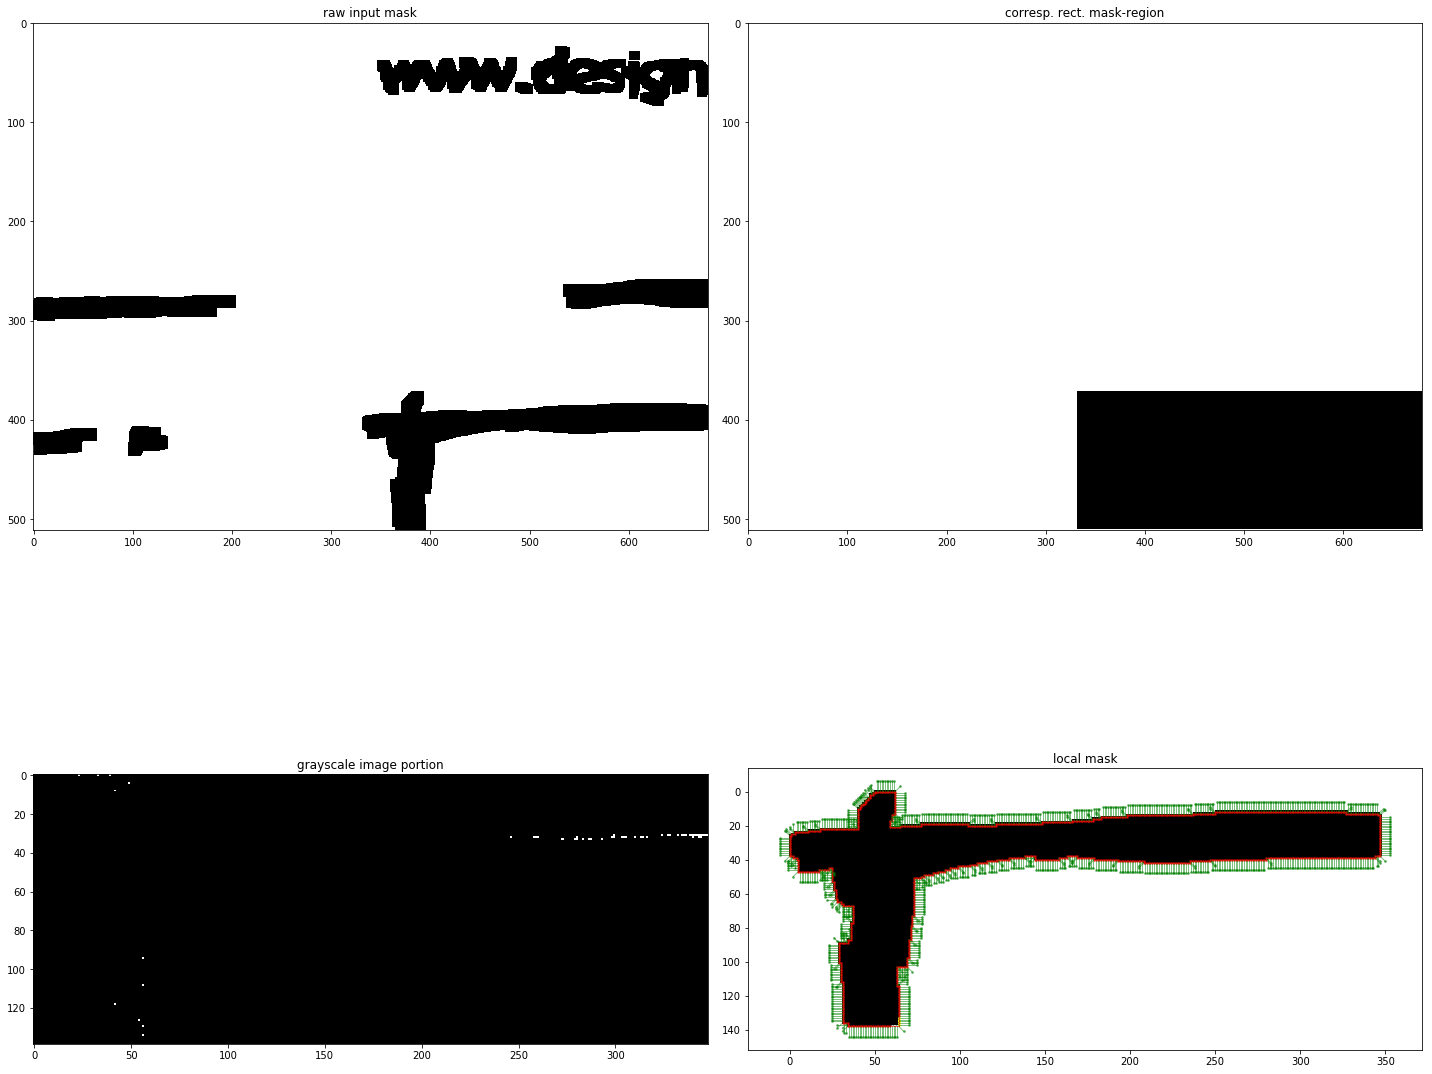

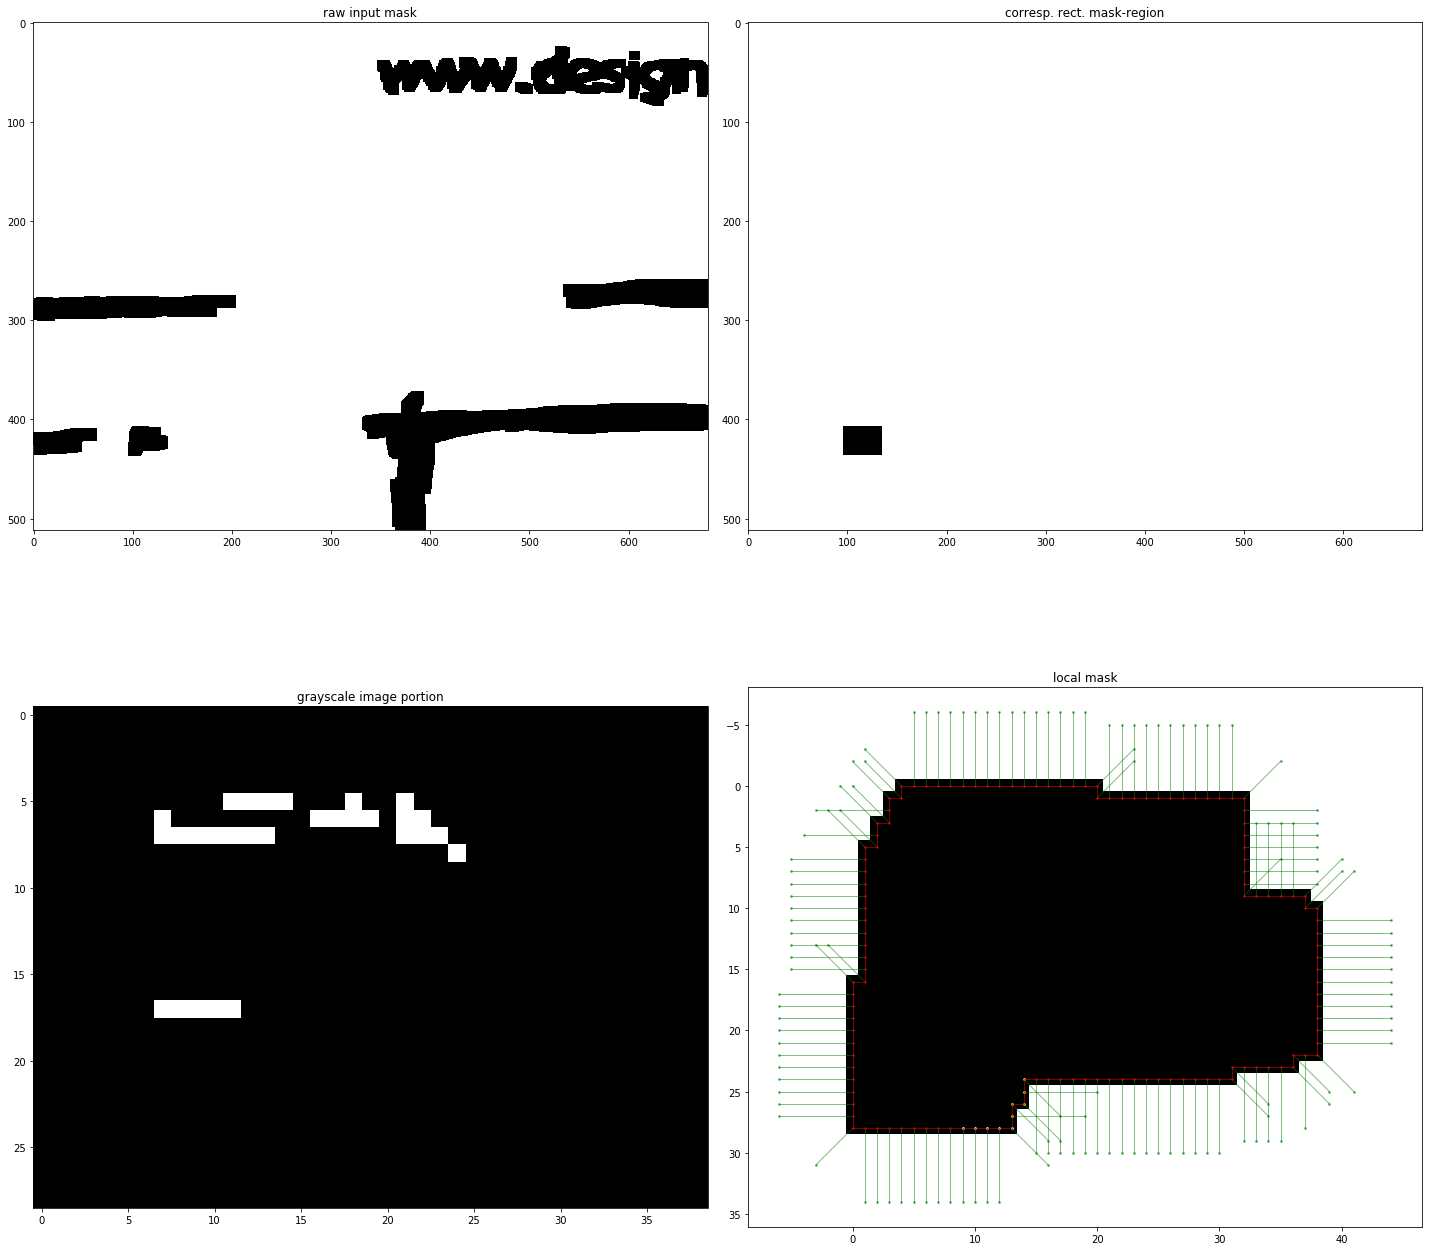

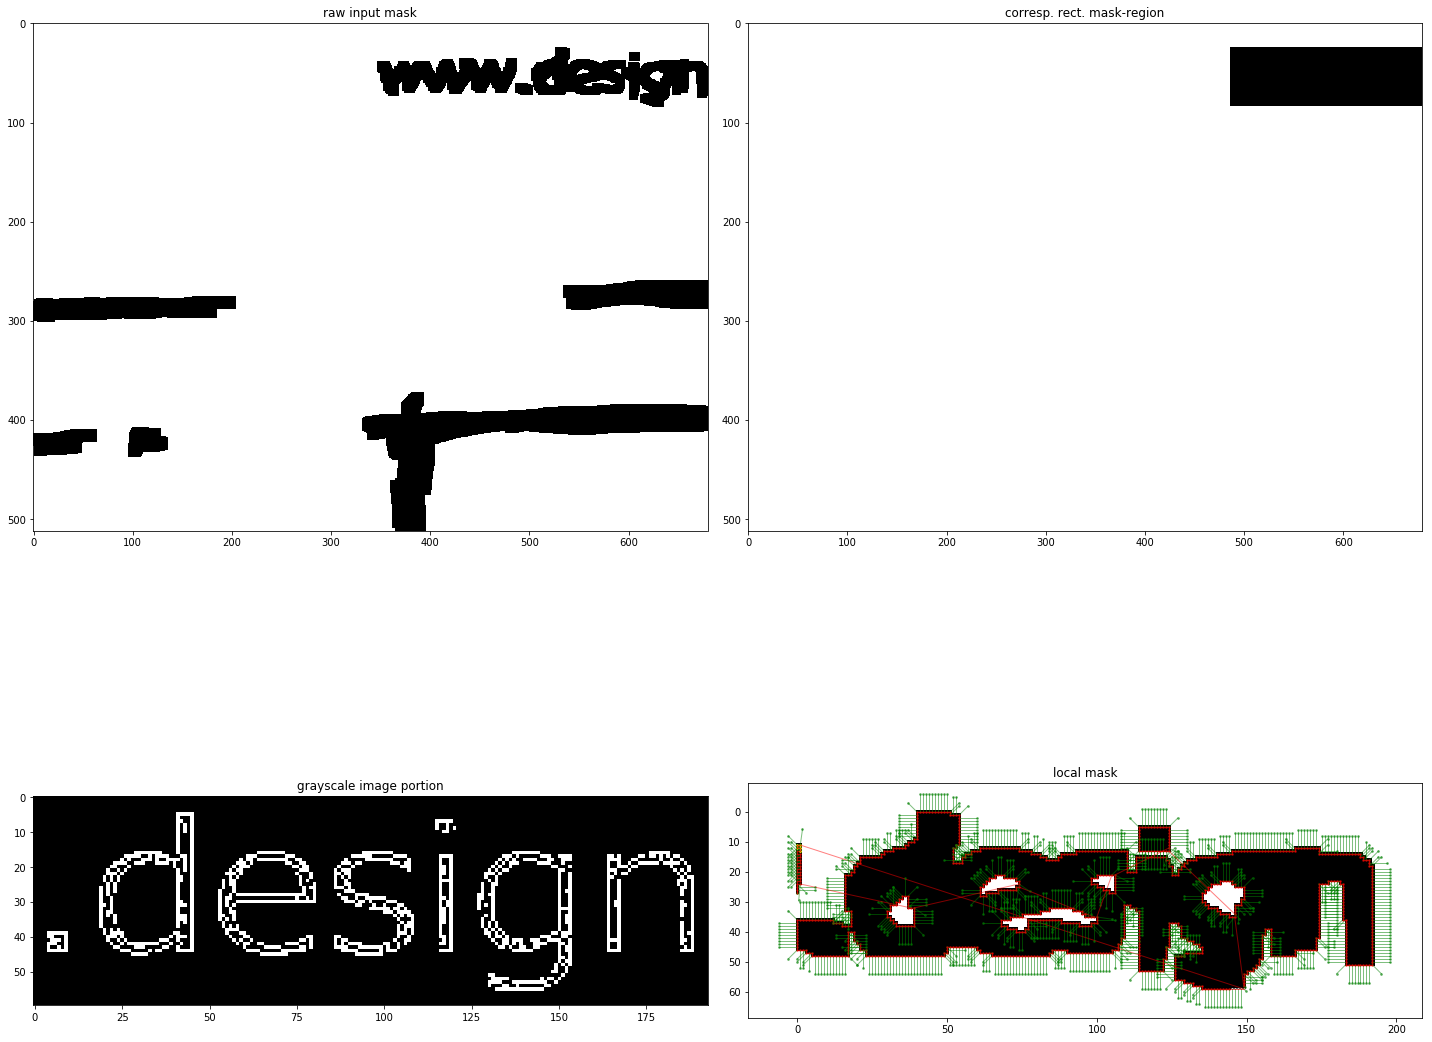

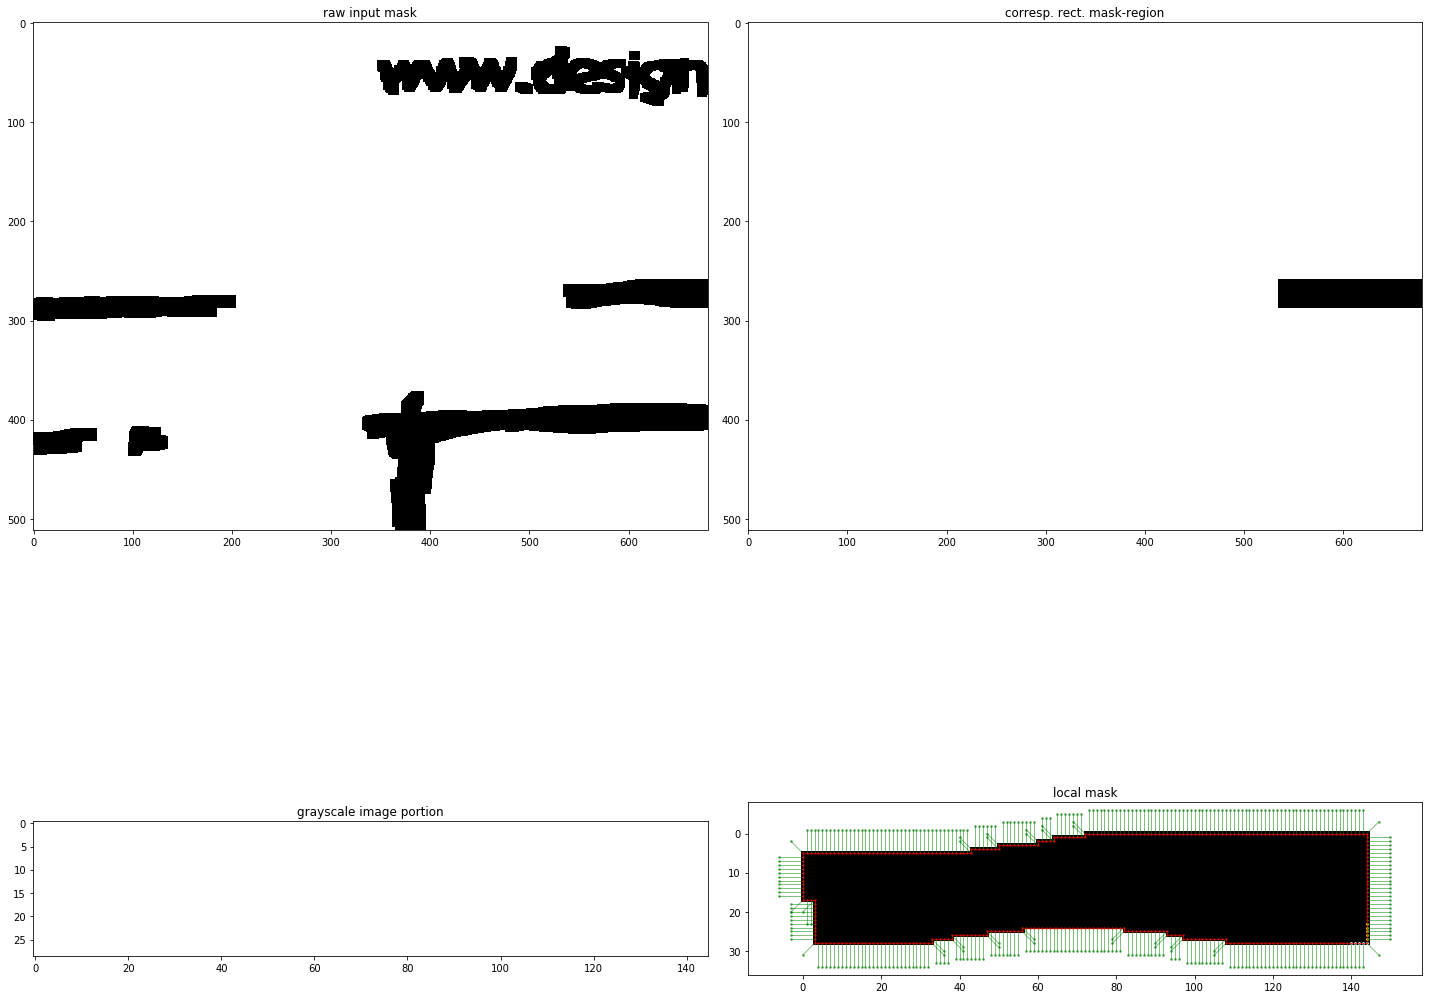

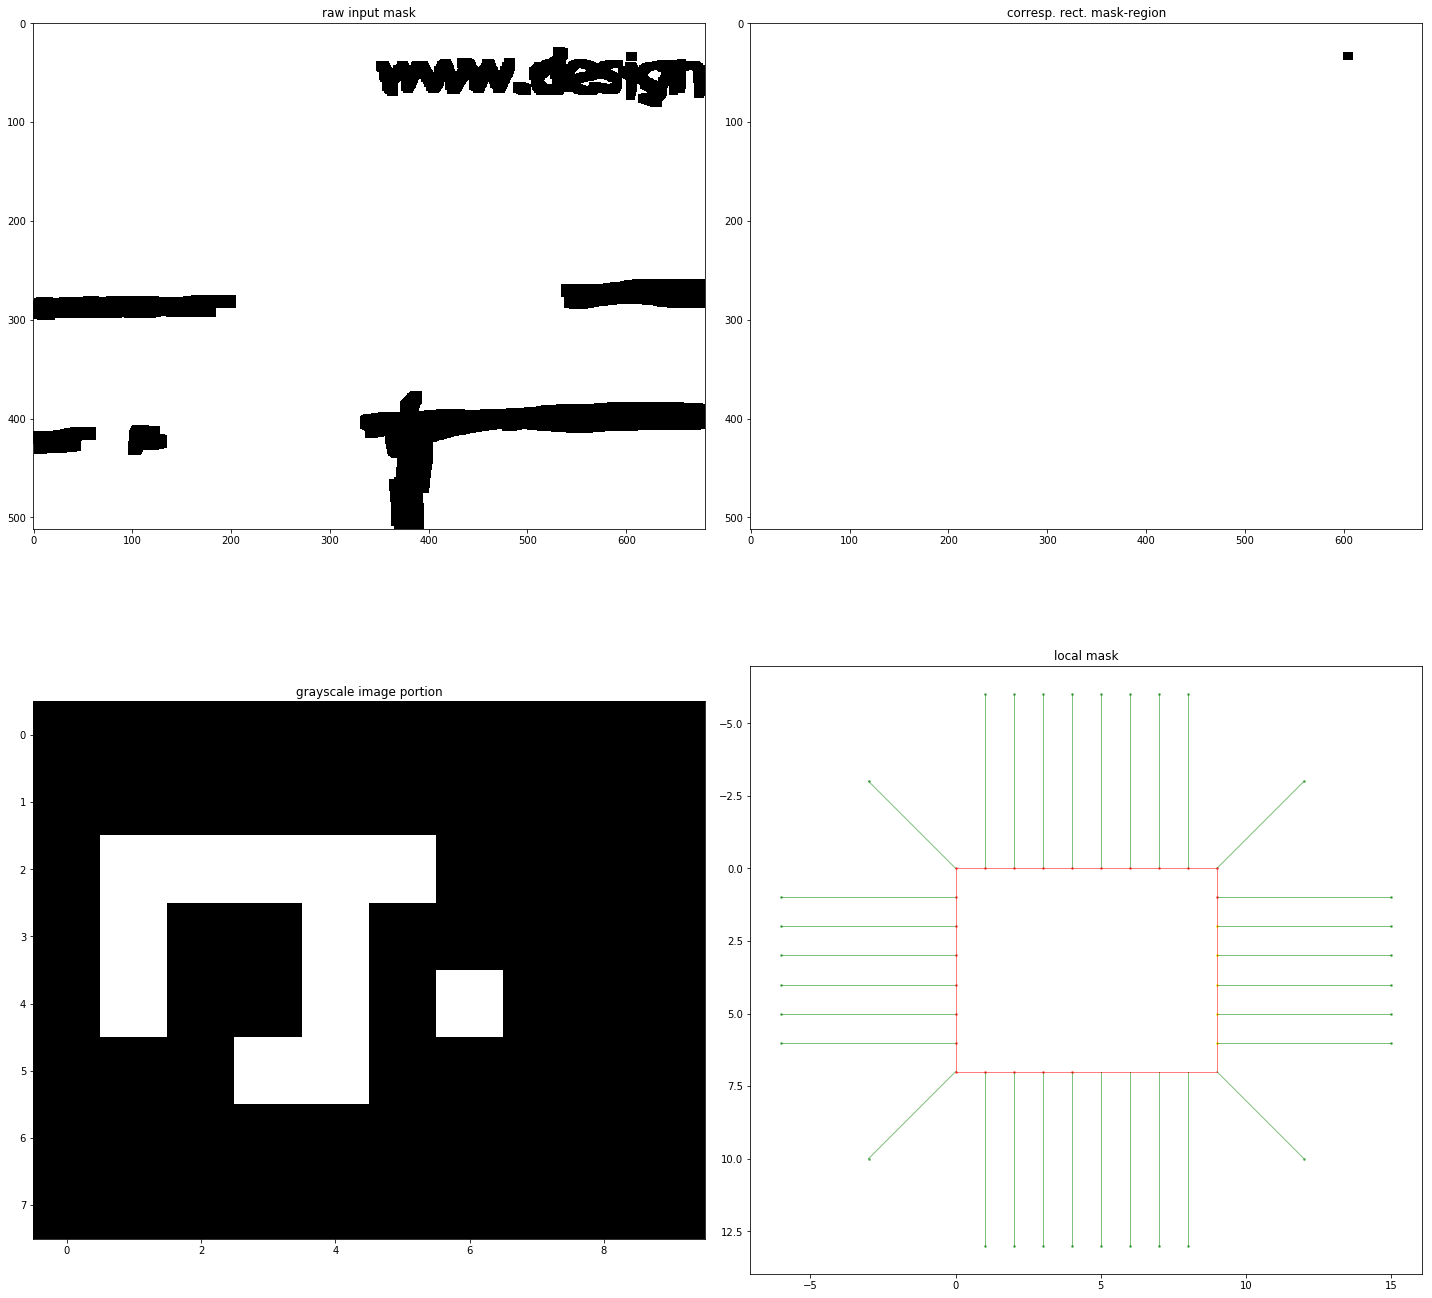

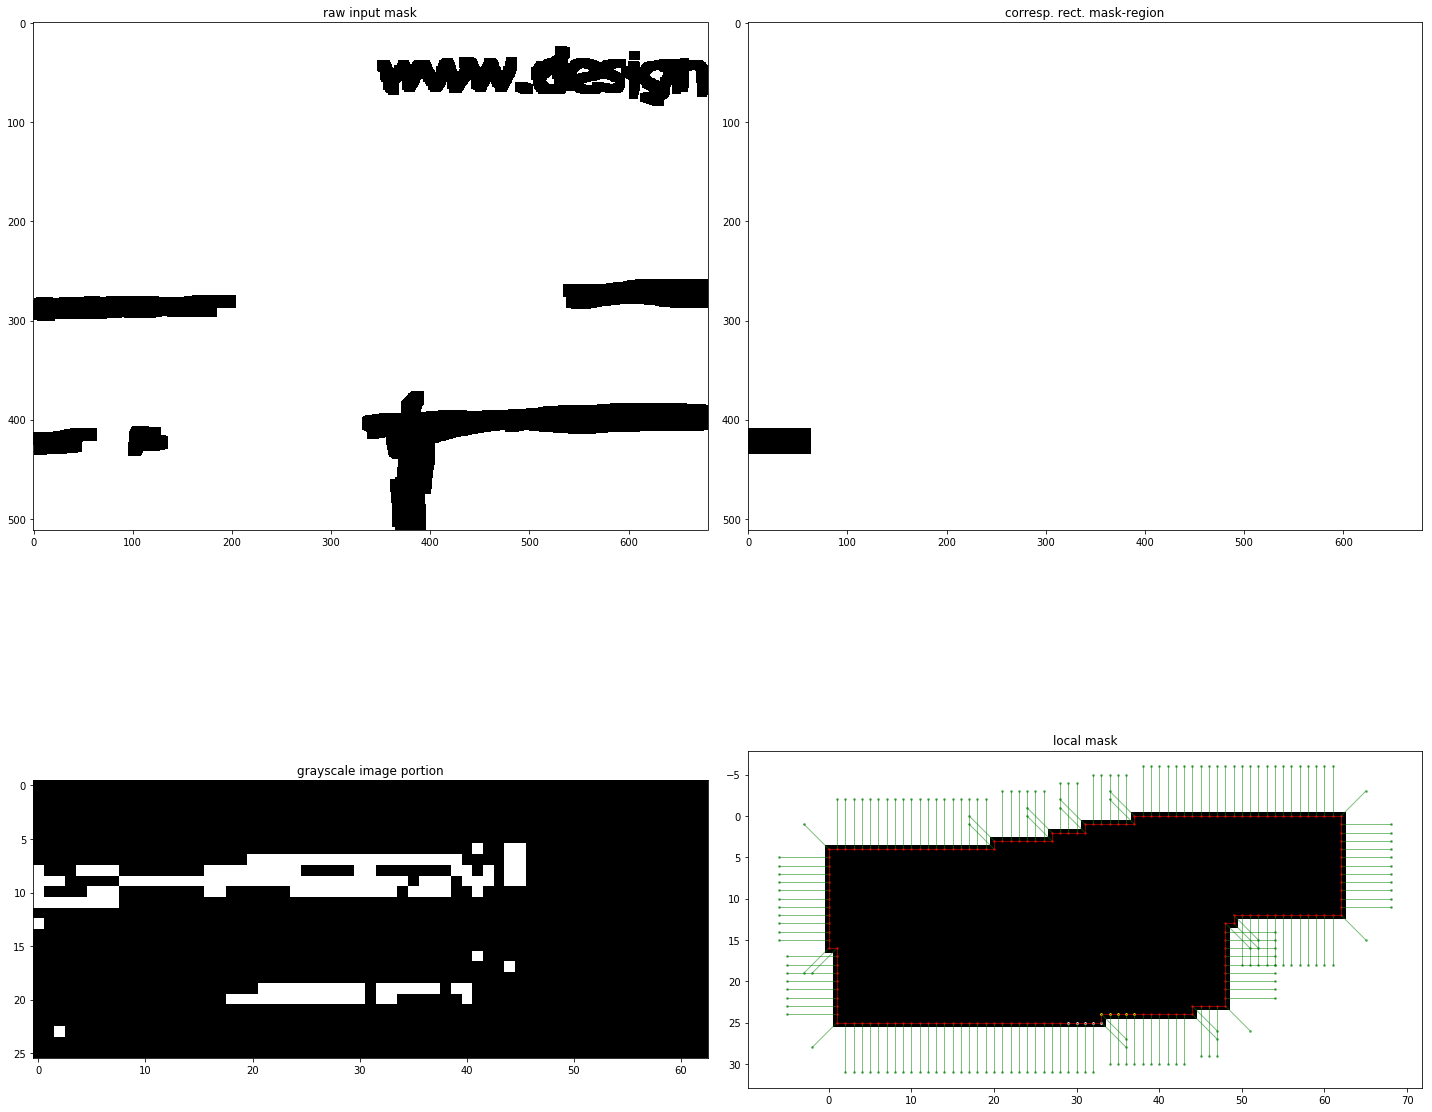

In [3]:
tsnakes = []

### Parameters for TSnakes ### 
sigma = 20.0  # gaussian filter sigma
p = 1.0       # scale final image force with p
c = 2.0       # scale gradient magnitude of image (applied before p)
a = 1.0       # tension parameter
b = 1.0       # bending parameter
gamma = 1.0   # friction coefficient
dt = 1.0      # time step
threshold = 10 # inflation force treshold

for region in regions:
    tsnake = region.initialize_tsnake(
        N=1000, p=p, c=c, sigma=sigma, a=a, b=b, gamma=gamma,
        dt=dt, threshold=threshold
    )
    tsnakes.append(tsnake)
    region.visualize() # NOTE: To show tsnakes on images, uncomment

# tsnakes.sort(key=lambda t: len(t.nodes))
# print("Length of T-Snakes initialized on image (sorted):\n{}".format(
#     [len(t.nodes) for t in tsnakes]))

### Initialize Ground Truth Snake
* NOTE: Looks like there are still some issues with the normal initialization which will need to be addressed in snake.py
* This ground truth will likely be improved if we can run it through a re-parametrization step

Empty region, continuing


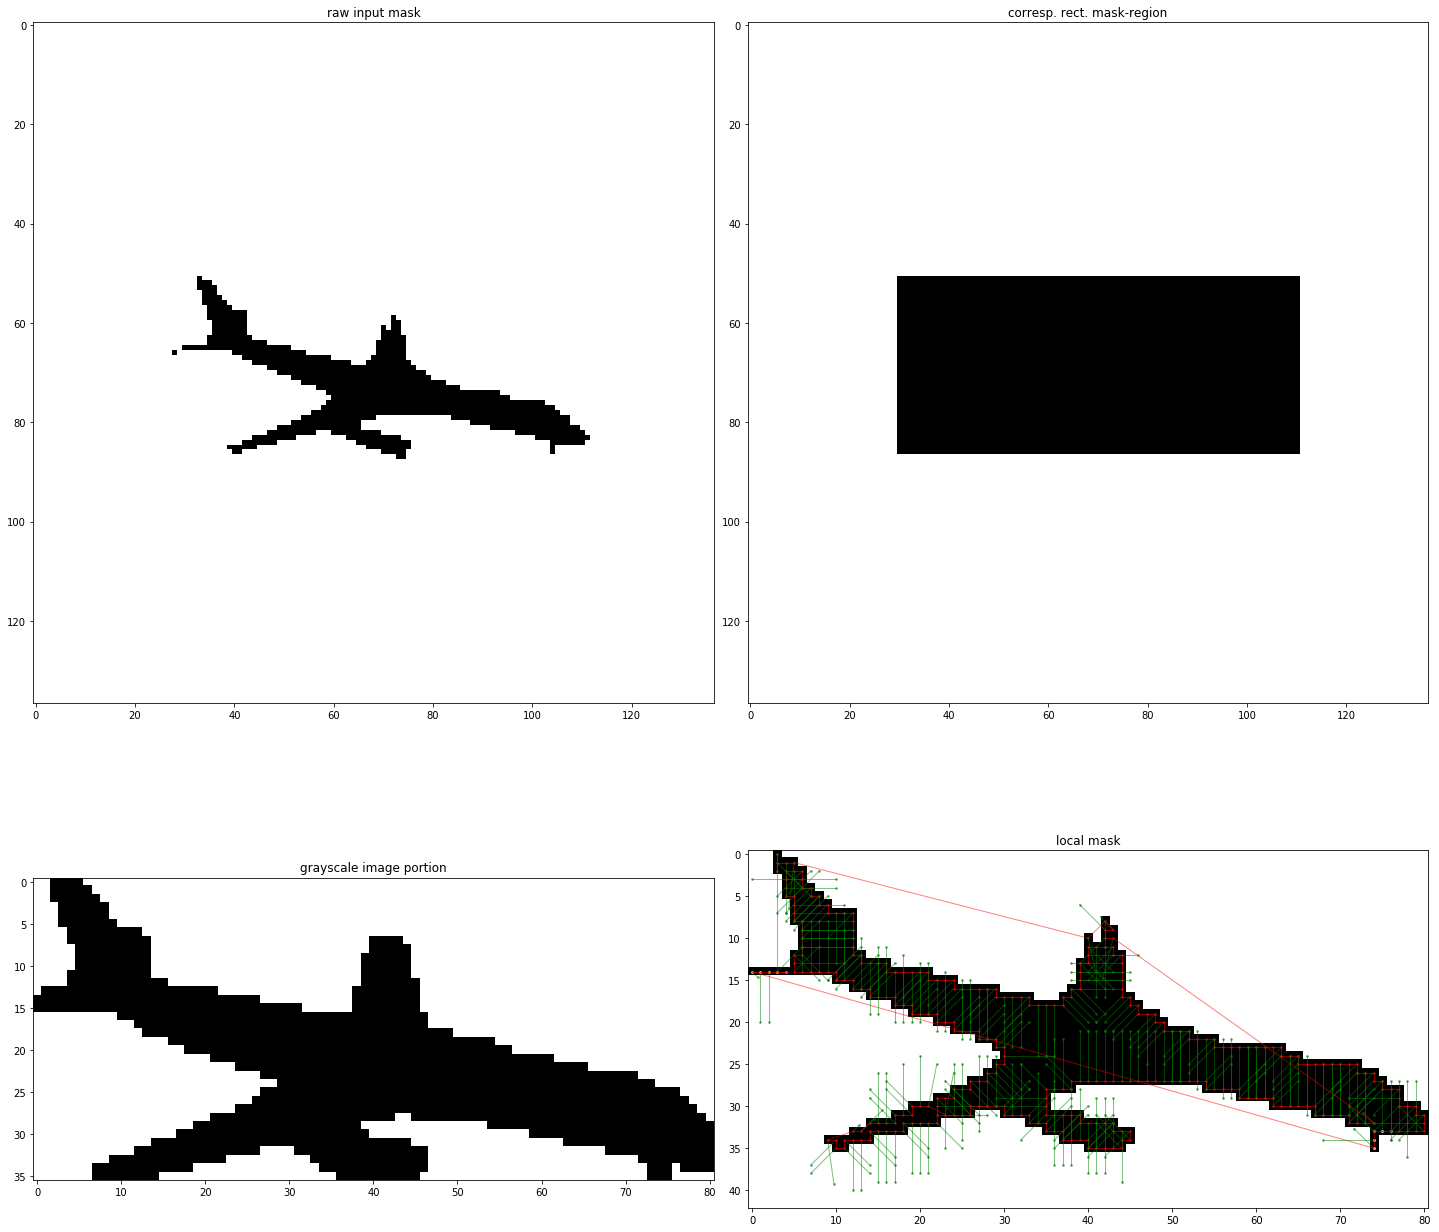

In [6]:
# assert len(gt_reigons) == 1, "There was more than one ground truth mask"
for region in gt_regions:
    try:
        tsnake = region.initialize_tsnake(
            N=1000, p=p, c=c, sigma=sigma, a=a, b=b, gamma=gamma,
            dt=dt
        )
        tsnakes.append(tsnake)
        region.visualize()
    except IndexError:
        print("Empty region, continuing")

## Create Grid and add Snakes to it

In [7]:
image = init.load_grayscale_image(img_path)
print(image.shape)
grid = Grid(image=image, scale=1)

# Update grid
# NOTE: Uncomment for force, expensive calculation
force = grid.get_image_force(2,2,2)
grid.gen_simplex_grid()
print("Simplex Grid shape: {}".format(grid.grid.shape))

# Add snakes to grid
for s in tsnakes:
    grid.add_snake(s)
    break

(137, 137)
Simplex Grid shape: (137, 137)


## Test Intersection Computation

In [8]:
# Compute snake intersections with grid
intersections = grid.get_snake_intersections()
# print(intersections)


## Test snake evolution

In [9]:
# Before:

regions[-1].show_snake(save_fig='images/img0.png')
# Test snake evolution
M = 20 # number of m-steps (iterations)

# Pick one of the snakes on the grid, they are sorted by size
snake = tsnakes[-1] 

# save the initial position of the snake
for i in tqdm(range(snake.num_nodes)):
    pos = snake.nodes[i].position

# run for M steps
for j in tqdm(range(M)):
    snake.m_step(1)

#     #save the updated positions of the nodes
#     for i in range(snake.num_nodes):
#         pos = snake.nodes[i].position
#         #print(pos)
#         X[i, j+1] = pos[0,0]
#         Y[i, j+1]= pos[0,1]

    regions[-1].show_snake(save_fig='images/img{}.png'.format(j+1))

c:\users\allen\appdata\local\programs\python\python37\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

## Visualize Evolution

In [ ]:
### TODO ###
# plt.imshow(image, cmap=plt.cm.binary)
colors = ['red', 'blue', 'orange', 'green','black']
# for i in tqdm(range(M)):
#     plt.clf()
#     plt.scatter(Y[:,i], X[:,i], c='red', s=1, alpha=0.5)
#     plt.savefig('images/img{}.png'.format(i))